# Saltwater Bubble Problem

This example simulates sinking of a circular saltwater inclusion in a freshwater domain.  The purpose of this notebook is to demonstrate MODFLOW 6 and its capability to simulate coupled variable-density groundwater flow and solute transport.

In [247]:
from IPython.display import HTML
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import flopy

In [248]:
mf6exe = "mf6"

In [249]:
def make_grid(nlay, nrow, ncol, lx, top0):
    top = np.zeros((nrow, ncol), dtype=float)
    botm = np.zeros((nlay, nrow, ncol), dtype=float)

    delr = lx / ncol
    delc = 1.
    delv = top0 / nlay
    top[:, :] = top0
    
    for k in range(nlay):
        tp = top0
        if k > 0:
            tp = botm[k - 1, 0, 0]
        botm[k, :, :] = tp - delv
    
    delr = np.ones(ncol) * delr
    delc = np.ones(nrow) * delc
    return (delr, delc, top, botm)

In [250]:
def create_simulation(
    ws,
    name,
    nlay,
    nrow,
    ncol,
    lx,
    top0,
    time_end,
    hydraulic_conductivity,
    specific_storage,
    porosity,
    alpha_l,
    alpha_t,
    cfresh,
    csalt,
    nstp=100,
    hstrt=None,
    cstrt=None,
    converge_continue=False,
    ats_percel=None,
    adv_scheme="UPSTREAM",
    verbosity_level=1,
):
    delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0)

    nper = 1
    perlen = nper * [time_end]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp, 1.0))

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-7, 1e-5, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        version="mf6",
        exe_name=mf6exe,
        verbosity_level=verbosity_level,
        sim_ws=ws,
    )
    if converge_continue:
        sim.name_file.continue_ = True
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units="DAYS", nper=nper, perioddata=tdis_rc)

    if ats_percel is not None:
        # set dt0, dtmin, dtmax, dtadj, dtfailadj
        dt0 = 0.01
        dtmin = 1.0e-5
        dtmax = perlen
        dtadj = 2.0
        dtfailadj = 5.0
        ats_filerecord = name + ".ats"
        atsperiod = [(0, dt0, dtmin, dtmax[i], dtadj, dtfailadj) for i in range(nper)]
        tdis.ats.initialize(
            maxats=len(atsperiod),
            perioddata=atsperiod,
            filename=ats_filerecord,
        )


    # create gwf model
    gwfname = "gwf_" + name
    gwtname = "gwt_" + name

    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, newtonoptions=True)
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        ats_outer_maximum_fraction=0.0,
        print_option="ALL",
        outer_hclose=hclose,
        outer_maximum=nouter,
        under_relaxation="DBD",
        inner_maximum=ninner,
        inner_hclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        no_ptcrecord=True,
        filename="{}.ims".format(gwfname),
    )
    single_matrix = False
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    dis = flopy.mf6.ModflowGwfdis(
        gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top, botm=botm
    )

    # initial conditions
    if hstrt is None:
        hstrt = top0
    else:
        hstrt = {
            "filename": "hstrt.bin",
            "factor": 1.0,
            "data": hstrt,
            "binary": "True",
        }
    ic = flopy.mf6.ModflowGwfic(gwf, strt=hstrt)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        xt3doptions=False,
        save_flows=True,
        save_specific_discharge=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )

    sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=1, sy=porosity, ss=specific_storage)

    pd = [(0, 0.7, 0.0, gwtname, "concentration")]
    buy = flopy.mf6.ModflowGwfbuy(gwf, packagedata=pd)

    # output control
    saverecord = {
        0: [("HEAD", "ALL"), ("BUDGET", "ALL")],
        1: [("HEAD", "ALL"), ("BUDGET", "ALL")],
        nper - 1: [("HEAD", "ALL"), ("BUDGET", "ALL")],
    }
    printrecord = {
        0: [("HEAD", "LAST"), ("BUDGET", "LAST")],
        1: None,
        nper - 1: [("HEAD", "ALL"), ("BUDGET", "LAST")],
    }
    oc = flopy.mf6.ModflowGwfoc(
        gwf,
        budgetcsv_filerecord=f"{gwfname}.bud.csv",
        budget_filerecord=f"{gwfname}.cbc",
        head_filerecord=f"{gwfname}.hds",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=saverecord,
        printrecord=printrecord,
    )

    # create gwt model
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file="{}.nam".format(gwtname),
    )

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            ats_outer_maximum_fraction=0.0,
            print_option="ALL",
            outer_hclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_hclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename="{}.ims".format(gwtname),
        )
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(
        gwt, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top, botm=botm
    )

    # initial conditions
    if cstrt is None:
        cstrt = csalt
    else:
        cstrt = {
            "filename": "cstrt.bin",
            "factor": 1.0,
            "data": cstrt,
            "binary": "True",
        }
    ic = flopy.mf6.ModflowGwtic(gwt, strt=cstrt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, ats_percel=ats_percel, scheme=adv_scheme)

    # dispersion
    dsp = flopy.mf6.ModflowGwtdsp(
        gwt, xt3d_off=False, diffc=0.0, alh=alpha_l, ath1=alpha_t
    )

    # mass storage and transfer
    porosity = porosity
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)

    # output control
    saverecord = {
        0: [("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
        1: [("CONCENTRATION", "ALL")],
        nper - 1: [("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
    }
    printrecord = {
        0: [("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        1: None,
        nper - 1: [("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
    }
    oc = flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.bud",
        budgetcsv_filerecord=f"{gwtname}.bud.csv",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=saverecord,
        printrecord=printrecord,
    )

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename="{}.gwfgwt".format(name),
    )

    return sim

In [251]:
def get_results(ws, sim):
    modelnames = list(sim.model_names)
    gwfname = modelnames[0]
    gwtname = modelnames[1]
    gwf = sim.get_model(gwfname)
    gwt = sim.get_model(gwtname)

    head = gwf.output.head().get_alldata()
    conc = gwt.output.concentration().get_alldata()
    times = gwt.output.concentration().get_times()

    budobj = gwf.output.budget()
    spdis = budobj.get_data(text='DATA-SPDIS')

    return head, conc, spdis, times

In [252]:
def add_streamplot(gwf, spdis, ax):
    x = gwf.modelgrid.xcellcenters
    y = gwf.modelgrid.zcellcenters
    X, Y = np.meshgrid(x, y[:, 0, 0])
    u = spdis['qx']
    u = u.reshape(X.shape)
    v = spdis['qz']
    v = v.reshape(X.shape)

    Y = Y[::-1, :]
    u = u[::-1, :]
    v = v[::-1, :]
    
    sc = ax.streamplot(X, Y, u, v, color='yellow', linewidth=0.1, arrowsize=0.35)
    

def make_figure(gwf, head, conc, spdis, t, top0, csalt=35., 
                ax2dict=None, asoln=None, streamplot=False, vectors=False,
                figname=None):

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect('equal')
    
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    pxs.plot_grid(alpha=1., lw=0.1)
    cb = pxs.plot_array(conc, vmin=0., vmax=csalt, cmap="jet")

    cbar = plt.colorbar(cb, shrink=0.5)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('CONCENTRATION, IN GRAMS PER LITER', rotation=90)
    
    if vectors:
        pxs.plot_specific_discharge(spdis, head=head, color='white',
                                    kstep=1, hstep=1, pivot='mid', minlength=0.5,
                                    scale=0.1, width=0.001, headwidth=3., headlength=5.0, 
                                    headaxislength=4.5, minshaft=0.01,
                                    zorder=10, alpha=0.50)
    
    if streamplot:
        add_streamplot(gwf, spdis, ax)

    ax.set_title('TIME = {:.2f} years'.format(t / 365.))
    ax.set_xlabel('DISTANCE, IN METERS')
    ax.set_ylabel('ELEVATION, IN METERS')
    
    plt.tight_layout()
   
    if figname is not None:
        plt.savefig(figname, dpi=300)
        plt.close(fig)
        
    return ax

In [253]:
# Protection
sim = None
sim0 = None
gwf = None
ws = None
ws0 = None
head = None
head0 = None
conc = None
conc0 = None

# Setup and run the Simulation

In [ ]:
# setup discretization and model parameters
nrow = 1
nlay = 20
ncol = 20
lx = 100.
lz = 100.
nstp = 100
time_end = 2000.
ats_percel = None
cfresh = 0.
csalt = 35.
porosity = 0.20
hydraulic_conductivity = 1. # m/day
specific_storage = 0.008 # per meter
alpha_l = 0. # meter
alpha_t = 0.0 # meter
adv_scheme = "UPSTREAM"

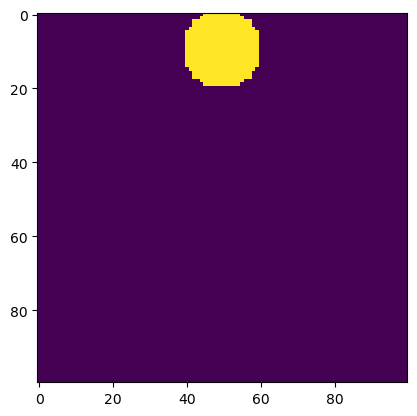

In [255]:
import flopy.discretization as fgrid
from shapely.geometry import Polygon
from flopy.utils.gridintersect import GridIntersect
dx = np.empty(ncol)
dx.fill(lx / ncol)
dy = np.empty(nlay)
dy.fill(lz / nlay)

# use a temporary grid for finding cells within saltwater circle
sgr = fgrid.StructuredGrid(dx, dy, top=None, botm=None)

radius = 10.
xmid = lx / 2.
ymid = 90.
    
theta = np.arange(0., 2*np.pi, 0.1)   
x = radius * np.cos(theta) + xmid
y = radius * np.sin(theta) + ymid
p = Polygon(shell=[(x, y) for x, y in zip(x, y)])
ix = GridIntersect(sgr, method='vertex')
result = ix.intersect(p, shapetype="polygon")
cstrt = np.zeros((nlay, nrow, ncol))
for k, j in result['cellids']:
    cstrt[k, 0, j] = csalt
plt.imshow(cstrt[:, 0, :])

In [256]:
ws0 = "./temp/blob"
name = "blob"
sim0 = create_simulation(
    ws0,
    name,
    nlay,
    nrow,
    ncol,
    lx,
    lz,
    time_end,
    hydraulic_conductivity,
    specific_storage,
    porosity,
    alpha_l,
    alpha_t,
    cfresh,
    csalt,
    nstp=nstp,
    cstrt=cstrt,
    ats_percel=ats_percel,
    adv_scheme=adv_scheme,
    verbosity_level=1,
)
sim0.write_simulation()
success, buff = sim0.run_simulation(silent=True, report=True)
assert success, "model failed"

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing package blob.ats...
  writing package blob.gwfgwt...
  writing model gwf_blob...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
INFORMATION: nrhospecies in ('', 'buy', 'dimensions') changed to 1 based on size of packagedata
    writing package oc...
  writing model gwt_blob...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...


In [257]:
# load results
head0, conc0, spdis0, times0 = get_results(ws0, sim0)
gwf = sim0.get_model('gwf_blob')
gwt = sim0.get_model("gwt_blob")

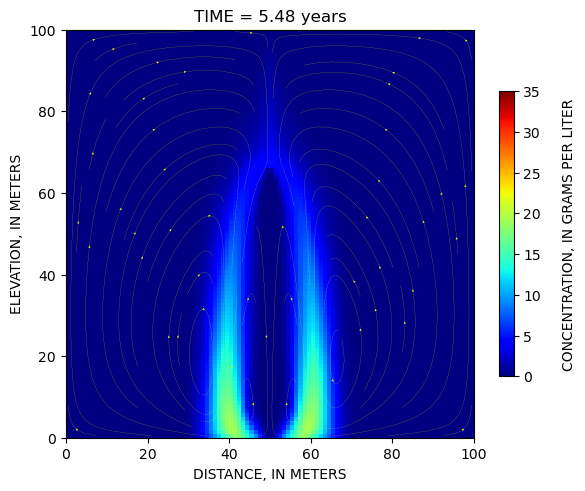

In [258]:
kper = -1
ax = make_figure(gwf, head0[kper], conc0[kper], spdis0[kper], 
                 times0[kper], lz, streamplot=True)

In [259]:
# load output
qx, qy, qz = None, None, None
head_all = gwf.output.head().get_alldata()
bud = gwf.output.budget()
times = bud.times
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
conc_all = gwt.output.concentration().get_alldata()
figsize = (8, 8)

In [260]:
times_to_show = times[::10]
ntimes = len(times_to_show)
bud = gwf.output.budget()
print (f"Number of time steps: {len(times)}")
print (f"{ntimes} frames will be added to animation.")

Number of time steps: 1319
132 frames will be added to animation.


In [261]:
def get_title(time_in_days):
    time_in_years = time_in_days / 365.
    return f"Time = {time_in_years:0.2f} years"

nplotrows = 1
nplotcols = 1
fig, axes = plt.subplots(
    nrows=nplotrows, 
    ncols=nplotcols, 
    figsize=figsize, 
    layout="constrained"
)
ax = axes
ax.set_ylabel(r'z')
title = ax.set_title(get_title(times[0]))
ax.set_xlabel(r'x')
#ax.set_xlim(0, 2.0)
#ax.set_ylim(0, 1.0)
ax.set_aspect(1.0)

# # plot persistent items
plot_array_dict = {
    "cmap": "jet",
    "masked_values": [1.e30],
}
colorbar_text_size = 10
pmv = flopy.plot.PlotCrossSection(gwt, line={"row": 0}, ax=ax)
pmv.plot_inactive()
pa = pmv.plot_array(
    conc_all[0], 
    vmin=0., 
    vmax=35., 
    **plot_array_dict
)
cb = plt.colorbar(pa, shrink=0.5)
cb.ax.set_ylabel('salinity (g/L)', rotation=270, fontsize=colorbar_text_size, labelpad=15)
cb.ax.tick_params(labelsize=colorbar_text_size)

def animate(i):
    print(".", end="", flush=True)
    itime = times.index(times_to_show[i])
    title = ax.set_title(get_title(times[itime]))
    pa = pmv.plot_array(
        conc_all[itime], 
        vmin=0., 
        vmax=35., 
        **plot_array_dict
    )
    # spdis = bud.get_data(text='DATA-SPDIS')[itime]
    # qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    # pmv.plot_vector(qx, qy, qz, normalize=False, color="white")

    return

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=ntimes)
plt.close()

# Create and show the animation in the notebook
HTML(ani.to_jshtml())

.....................................................................................................................................

In [262]:
# Activate to save as gif
# writer = matplotlib.animation.PillowWriter(fps=20) # Adjust fps as needed
# ani.save('blob_animation.gif', writer=writer)

In [ ]:
# Plans for exercise:
# Run with specified time steps, upstream advection, no dispersion
# Increase grid resolution (suggest not going over nlay=100, ncol=100)
# Turn on ATS
# Test advection schemes
# Add dispersion

# Extra credit: How do you make an animation with even temporally spaced frames